# Visualize and preprocessing data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors 
import math 
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import shapely
import geopandas as gpd
import fiona

In [2]:
def scale(array):
    arr_min = array.min(axis=(0, 1))
    arr_max = array.max(axis=(0, 1))
    return (array - arr_min) / (arr_max - arr_min)

scale array to reduce gradient exploding

In [3]:
dataset = rasterio.open('../input/mi3380-project1-hust/img.tif')
polygons = gpd.read_file('../input/mi3380-project1-hust/shp/paddy_bg.shp')

Check their're coordinates

In [4]:
print("Dataset's crs ", dataset.crs)
print("Polygons's crs ", polygons.crs)

Dataset's crs  EPSG:4326
Polygons's crs  {'init': 'epsg:4326'}


In [5]:
rgb = dataset.read()
rgb.shape

(4, 608, 552)

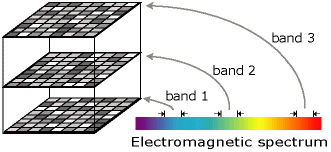

In [6]:
band = []
for i in range (4):
    band.append(dataset.read(i+1))
band = np.asarray(band)

Text(0.5, 1.0, 'Band 4 (Near Infrared)')

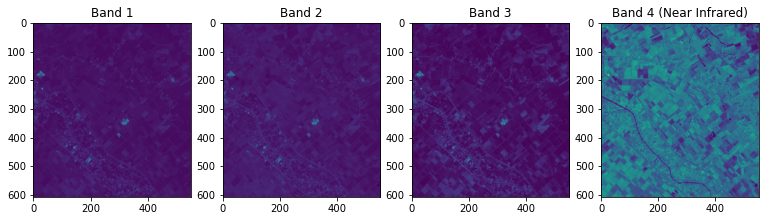

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(13, 13))
ax[0].imshow(band[0])
ax[0].set_title('Band 1')
ax[1].imshow(band[1])
ax[1].set_title('Band 2')
ax[2].imshow(band[2])
ax[2].set_title('Band 3')
ax[3].imshow(band[3])
ax[3].set_title('Band 4 (Near Infrared)')

In [8]:
polygons

,id,class,geometry
0,2,background,"POLYGON ((100.28420 14.91774, 100.28577 14.917..."
1,6,background,"POLYGON ((100.27480 14.91275, 100.27596 14.912..."
2,4,background,"POLYGON ((100.29281 14.90680, 100.29553 14.906..."
3,1,background,"POLYGON ((100.28476 14.89899, 100.28649 14.898..."
4,7,background,"POLYGON ((100.31295 14.91959, 100.31561 14.919..."
5,5,background,"POLYGON ((100.30881 14.94158, 100.31043 14.941..."
6,4,paddy,"POLYGON ((100.31228 14.94691, 100.31445 14.947..."
7,5,paddy,"POLYGON ((100.29092 14.94459, 100.29296 14.945..."
8,2,paddy,"POLYGON ((100.30275 14.94276, 100.30356 14.943..."
9,3,paddy,"POLYGON ((100.30217 14.93642, 100.30332 14.937..."


In [9]:
poly_background = polygons.iloc[:6, :]
poly_paddy = polygons.iloc[6:, :]

In [10]:
shapes_paddy = []
geo = poly_paddy.values[:, 2]
for i in range(len(poly_paddy)):
    shapes_paddy.append(geo[i])
shapes_background = []
geo = poly_background.values[:, 2]
for i in range(len(poly_background)):
    shapes_background.append(geo[i])  

In [11]:
shapes_paddy

In [12]:
masks_paddy = rasterio.mask.raster_geometry_mask(dataset, shapes_paddy)[0].astype(np.int8)
masks_background = rasterio.mask.raster_geometry_mask(dataset, shapes_background)[0].astype(np.int8)

Text(0.5, 1.0, 'Background')

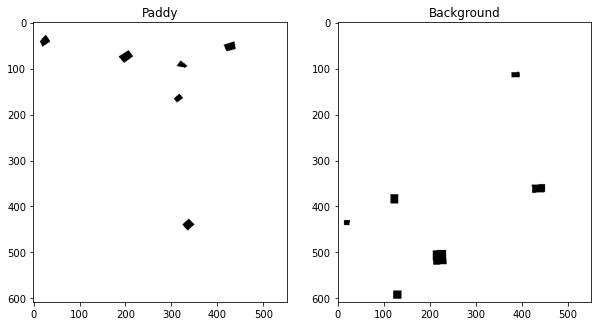

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(masks_paddy, cmap = 'gray')
ax[0].set_title('Paddy')
ax[1].imshow(masks_background, cmap = 'gray')
ax[1].set_title('Background')

In [14]:
pixels_paddy = []
pixels_background = []
for i in range (len(masks_paddy)):
  for j in range (len(masks_paddy[0])):
    if (masks_paddy[i, j] == 0):
      pixels_paddy.append([i, j])
    if (masks_background[i, j] == 0):
      pixels_background.append([i, j])

In [15]:
samples_paddy = []
samples_background = []

for i in range (len(pixels_paddy)): 
  pixels = np.zeros(4) 
  for j in range (4):
    pixels[j] = dataset.read(j + 1)[pixels_paddy[i][0], pixels_paddy[i][1]]
  samples_paddy.append(pixels)

for i in range (len(pixels_background)): 
  pixels = np.zeros(4) 
  for j in range (4):
    pixels[j] = dataset.read(j + 1)[pixels_background[i][0], pixels_background[i][1]]
  samples_background.append(pixels)

samples_paddy = np.asarray(samples_paddy)
samples_background = np.asarray(samples_background)

In [16]:
print('Shape of samples_paddy: ', samples_paddy.shape)
print('Shape of samples_background: ', samples_background.shape)

Shape of samples_paddy:  (1830, 4)
Shape of samples_background:  (2413, 4)


In [17]:
df_paddy = pd.DataFrame({ 'Band 1' : samples_paddy[:,0],
                    'Band 2' : samples_paddy[:,1],
                    'Band 3' : samples_paddy[:,2],
                    'Band 4' : samples_paddy[:,3],
                    'Label' : 'paddy'})
df_background = pd.DataFrame({ 'Band 1' : samples_background[:,0],
                    'Band 2' : samples_background[:,1],
                    'Band 3' : samples_background[:,2],
                    'Band 4' : samples_background[:,3],
                    'Label' : 'background'})

In [18]:
print("Paddy Dataframe")
print(df_paddy.head())
print("Shape: ", df_paddy.shape)
print("----------------------------------------------")
print("Background Dataframe")
print(df_background.head())
print("Shape: ", df_background.shape)

Paddy Dataframe
   Band 1  Band 2  Band 3  Band 4  Label
0  1091.0  1115.0   716.0  3034.0  paddy
1  1090.0  1093.0   670.0  2975.0  paddy
2  1154.0  1068.0   833.0  1865.0  paddy
3  1086.0  1105.0   689.0  2515.0  paddy
4  1096.0  1103.0   704.0  2473.0  paddy
Shape:  (1830, 5)
----------------------------------------------
Background Dataframe
   Band 1  Band 2  Band 3  Band 4       Label
0  1151.0  1037.0   901.0  1711.0  background
1  1125.0  1008.0   858.0  1711.0  background
2  1125.0  1008.0   858.0  1711.0  background
3  1096.0   989.0   767.0  1971.0  background
4  1104.0  1019.0   753.0  2072.0  background
Shape:  (2413, 5)


# Artificial Neural Network - ANN

In [19]:
def scale(array):
    arr_min = array.min(axis=(0, 1))
    arr_max = array.max(axis=(0, 1))
    return (array - arr_min) / (arr_max - arr_min)

In [20]:
frames = [df_paddy, df_background]
df = pd.concat(frames)

In [21]:
df = pd.get_dummies(df, columns=['Label'])

In [22]:
df.head()

,Band 1,Band 2,Band 3,Band 4,Label_background,Label_paddy
0,1091.0,1115.0,716.0,3034.0,0,1
1,1090.0,1093.0,670.0,2975.0,0,1
2,1154.0,1068.0,833.0,1865.0,0,1
3,1086.0,1105.0,689.0,2515.0,0,1
4,1096.0,1103.0,704.0,2473.0,0,1


In [23]:
X = df.values[:, 0:4].astype(float)
y = df.values[:, 4:6].astype(float)
X = scale(X)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
from keras.models import Sequential 
from keras.layers import Dense 
from keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [26]:
def create_network():
    model = Sequential()
    model.add(Dense(32, input_shape=(4,), activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
        
    return model

In [27]:
earlyStopping = EarlyStopping(patience=10, verbose=0)
mcp_save = ModelCheckpoint('model.h5', verbose=0, save_best_only=True, save_weights_only=True)
reduce_lr_loss = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=0)
callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [28]:
model = create_network()
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [29]:
results = model.fit(X_train,Y_train, epochs=50, batch_size=32, callbacks = callbacks, validation_data=(X_test, Y_test), verbose = 0)

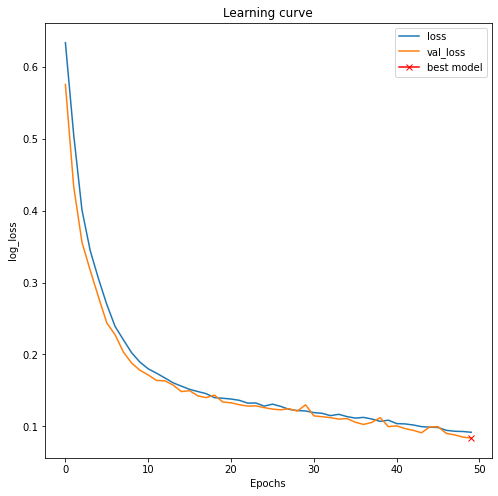

In [30]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [31]:
model.evaluate(X_test, Y_test, verbose=1)

34/34 [==============================] - 0s 2ms/step - loss: 0.0838 - accuracy: 0.9708


[0.08378415554761887, 0.9707822799682617]

# Peredict pixel is paddy or background

In [32]:
dataset = rasterio.open('../input/mi3380-project1-hust/img.tif')

In [33]:
rgb = np.transpose(dataset.read(), (1, 2, 0))
rgb.shape

(608, 552, 4)

In [34]:
band1 = np.reshape(dataset.read(1), -1)
band2 = np.reshape(dataset.read(2), -1)
band3 = np.reshape(dataset.read(3), -1)
band4 = np.reshape(dataset.read(4), -1)

In [35]:
fully_df = pd.DataFrame({'Band 1': band1,
                    'Band 2' : band2,
                    'Band 3' : band3,
                    'Band 4' : band4})
Observation = scale(fully_df.values)

In [36]:
def model_predict(X):
    result = model.predict(X)
    for i in range (len(X)):
        if (result[i, 1] >= 0.6):
            print(X[i, :], ' is paddy')
        if (result[i, 1] < 0.6 and result[i, 1] > 0.5):
            print(X[i, :], '  may be paddy')
        else:
            print(X[i, :], ' is background')

In [37]:
model_predict(Observation[80:100, :])

[0.11320426 0.10151753 0.0825048  0.2967033 ]  is background
[0.11320426 0.10151753 0.0825048  0.2967033 ]  is background
[0.11459969 0.09907553 0.08651666 0.25920112]  is background
[0.11198325 0.09279609 0.07395779 0.20617478]  is background
[0.11477411 0.09593581 0.08058608 0.20966335]  is background
[0.11372754 0.09611024 0.0812838  0.21070992]  is background
[0.11111111 0.09506367 0.07744636 0.2039072 ]  is background
[0.11058782 0.09488924 0.07884179 0.20129077]  is background
[0.11076225 0.09314495 0.0758765  0.19710448]  is background
[0.11093668 0.09227281 0.07552765 0.20076749]  is background
[0.11145997 0.09401709 0.07500436 0.2002442 ]  is background
[0.11145997 0.09401709 0.07500436 0.2002442 ]  is background
[0.11634397 0.09872667 0.07919065 0.21367521]  is background
[0.11739055 0.10186639 0.08948195 0.22169894]  is background
[0.11843712 0.10448282 0.08669109 0.2190825 ]  is background
[0.11721612 0.10116867 0.08686552 0.20983778]  is background
[0.11686726 0.0989011  0

In [38]:
def predict(pixel):
    X = np.zeros((1, 4))
    for i in range (4):
        X[0, i] = dataset.read(i+1)[pixel[0], pixel[1]]
    result = model.predict(X)
    if (result[0, 1] >= 0.7):
        print(pixel, ' is paddy')
    if (result[0, 1] < 0.7 and result[0, 1] > 0.5):
        print(pixel, '  may be paddy')
    else:
        print("pixel (",pixel[0],", ", pixel[1],") is background")